# GAN Implementation

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
random.seed(2003)

In [4]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

In [5]:
random_idx = random.randint(0, len(xTrain) - 1)

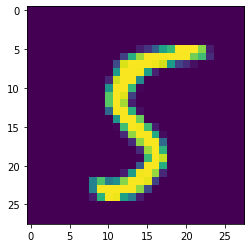

In [6]:
plt.imshow(xTrain[random_idx])

In [7]:
yTrain[random_idx]

5

In [8]:
yTrain

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [9]:
'''we will filter out the data to get a little bit of a smaller dataset for faster training, 
and to clearly understand the generator is working properly or not.'''

only_zeros = xTrain[yTrain == 0]
only_zeros.shape

(5923, 28, 28)

In [10]:
xTrain.shape

(60000, 28, 28)

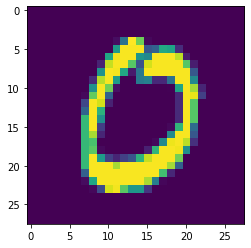

In [11]:
random_idx = random.randint(0, len(only_zeros) - 1)
plt.imshow(only_zeros[random_idx])

In [12]:
discriminator = Sequential()

discriminator.add(Flatten(input_shape= [28, 28]))
discriminator.add(Dense(150, activation= 'relu'))
discriminator.add(Dense(100, activation= 'relu'))
# FINAL OUTPUT — IS IMAGE FAKE OR NOT? (BINARY CLF)
discriminator.add(Dense(1, activation= 'sigmoid'))

Metal device set to: Apple M1


2022-08-06 00:06:47.806251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-06 00:06:47.806375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
discriminator.compile(optimizer= 'adam', loss= 'binary_crossentropy')

In [14]:
codingsSize = 100
# 784 (28 ^ 2) --> 150 --> 100 --> 150 --> 784

generator = Sequential()
#  what's reliant on this first layering generator below is the input_shape.
generator.add(Dense(100, activation= 'relu', input_shape= [codingsSize]))
generator.add(Dense(150, activation= 'relu'))
generator.add(Dense(784, activation= 'relu'))
generator.add(Reshape(target_shape= [28, 28]))

In [15]:
# instead of compiling generator first, create GAN

GAN = Sequential([generator, discriminator])

In [16]:
discriminator.trainable = False

In [17]:
GAN.compile(optimizer= 'adam', loss= 'binary_crossentropy')

### Training Batches

In [18]:
batch_size = 32 # to make training model go faster increase the batch size

In [19]:
# my_data = xTrain
my_data = only_zeros

In [20]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size= 1000)

In [21]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [22]:
dataset = dataset.batch(batch_size, drop_remainder= True).prefetch(1)

In [23]:
my_data.shape

(5923, 28, 28)

In [24]:
5923 / 32

185.09375

In [25]:
# the .09375 part of the batch will be dropped due to the drop_remainder param
# clean batches = 185

In [26]:
epochs = 1 # train for one epoch, and after that we should be able to see start generating zeros

In [27]:
GAN

In [28]:
GAN.layers

In [29]:
GAN.layers[0].layers # generator

In [30]:
GAN.layers[1].layers # discriminator

In [31]:
# summaries of generator and discriminator

GAN.layers[0].summary()
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
____________________________

In [32]:
# unpacking the model to list of layers

generator, discriminator = GAN.layers

for epoch in range(epochs):
    print(f'Currently on Epoch {epoch + 1}')
    i = 0
    
    for xBatch in dataset:
        i += 1
        if i % 10 == 0:
            print(f'\t Currently on batch number {i} of {len(my_data) // batch_size}')
        
        # DISCRIMINATOR TRAINING PHASE 
        noise = tf.random.normal(shape= [batch_size, codingsSize])
        # the generator never actually sees any mnist digits images, only noise being fed onto it
        generated_images = generator(noise)
        X_fake_vs_real = tf.concat([generated_images, tf.dtypes.cast(xBatch, tf.float32)], axis= 0)
        
        y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
        # 0's --> not true for the generated_images
        # 1's --> true for the actual images on the xBatch
        
        discriminator.trainable = True
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        # TRAIN GENERATOR
        # create some random noise again
        noise = tf.random.normal(shape= [batch_size, codingsSize])
        y2 = tf.constant([[1.0]] * batch_size)
        discriminator.trainable = False
        GAN.train_on_batch(noise, y2)

Currently on Epoch 1


2022-08-06 00:06:48.164800: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-06 00:06:48.165501: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-06 00:06:48.165550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-06 00:06:48.372170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


	 Currently on batch number 10 of 185
	 Currently on batch number 20 of 185
	 Currently on batch number 30 of 185
	 Currently on batch number 40 of 185
	 Currently on batch number 50 of 185
	 Currently on batch number 60 of 185
	 Currently on batch number 70 of 185
	 Currently on batch number 80 of 185
	 Currently on batch number 90 of 185
	 Currently on batch number 100 of 185
	 Currently on batch number 110 of 185
	 Currently on batch number 120 of 185
	 Currently on batch number 130 of 185
	 Currently on batch number 140 of 185
	 Currently on batch number 150 of 185
	 Currently on batch number 160 of 185
	 Currently on batch number 170 of 185
	 Currently on batch number 180 of 185


In [33]:
# arbitrarily chosen number of fake images, let's say 10
noise = tf.random.normal(shape= [10, codingsSize])

In [34]:
noise.shape

TensorShape([10, 100])

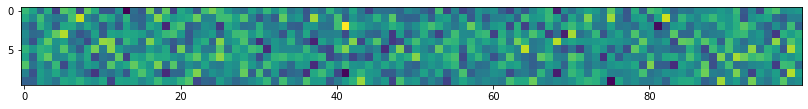

In [35]:
plt.figure(figsize= (14, 6))
plt.imshow(noise)

In [36]:
images = generator(noise)

In [37]:
images.shape

TensorShape([10, 28, 28])

In [38]:
images[0]

<tf.Tensor: shape=(28, 28), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 

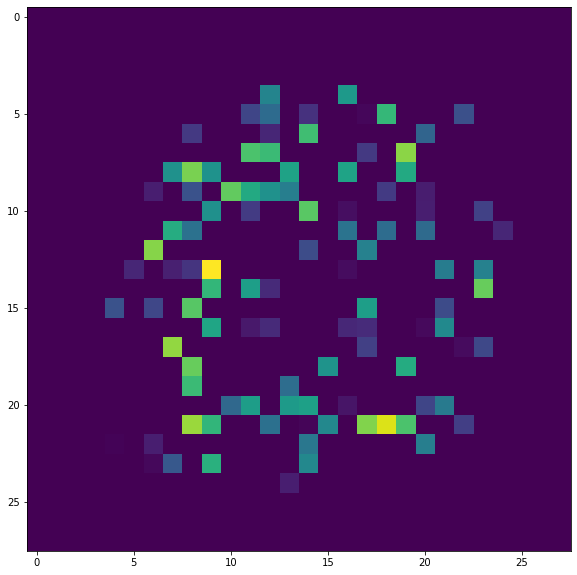

In [39]:
plt.figure(figsize= (10, 10))
plt.imshow(images[0])